# UE IA pour la robotique: TP - Planification de mouvement

### Infos pratiques :

- À faire seul ou en binôme.
- Un compte-rendu est à rendre au plus tard une semaine après la fin du TP.
- Pour chaque résultat présenté dans le compte-rendu, le code et les instructions permettant de reproduire ce résultat doivent être fournis.

In [81]:
import numpy as np
import sys
import random
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# Partie 1

### Q1. Lire et comprendre le fichier “part1.py”.

La classe Env décrit un très simple environnement 2D borné dans [-1,1] x [-1, 1] et comprenant des “murs” représentés par des segments de droite.
La méthode la plus importante de cette classe est la fonction step, qui prend en entrée un état state (un vecteur 2D), et une action action, qui est également un vecteur 2D , mais borné à l’intérieur de [-0.1,0.1] x [-0.1,0.1]. Cette fonction vérifie que le segment de state à state+action n’intersecte pas les murs de l’environnement. S’il y a intersection, le segment est rétrécit jusqu’à la première intersection rencontrée depuis state (on imagine un trajet en ligne droite qui se heurte au mur). Le nouvel état est renvoyé par la fonction, sauf si le segment est considéré trop petit, auquel cas False est renvoyé. Des détails d’implémentation complètent la fonction pour éviter l’apparition de certains bugs.

La classe Tree sert à gérer l’arbre d’exploration. À chaque noeud de l’arbre correspond un état (state), c’est-à-dire un point dans l’environnement. Un noeud a également des noeuds fils (la liste successors). À la racine de l’arbre, le paramètre all_nodes doit contenir la liste de tous les autres noeud de l’arbre. Il donne un accès direct qui simplifiera la sélection des noeuds pour l’exporation. Ailleurs qu’à la racine, all_nodes est toujours une liste vide.
Dans les exemples suivants on mettra la racine de l’arbre (l’état initial) à [-0.5,0.5]. 

Exécutez part1.py. Vous devriez obtenir le résultat suivant :

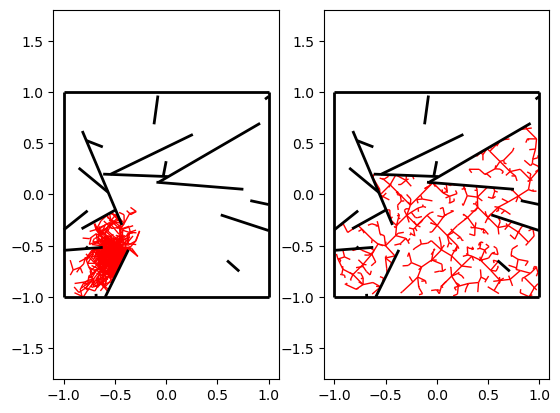

In [2]:
from part1 import *

Vous pouvez modifier la ligne random_seed = 11 pour changer le seed et obtenir un autre environnement. Ce seed impacte à la fois l'environnement (les murs sont choisis aléatoirement) et l'exécution des algorithmes. Modifiez la gestion des seeds pour vous permettre d'obtenir des explorations aléatoires variables dans un environnement fixé. 

Le résultat initial affiché à gauche est une recherche aléatoire naïve depuis le point (-0.5, -0.5), effectuée grâce à des appels successifs à la fonction random_expansion(), qui sélectionne un noeud de l’arbre aléatoirement puis l’étend avec une action alétoire.

rrt_expansion() est une implémentation inefficace de RRT (résultat affiché à droite), qui à chaque itération parcourt tous les noeuds de l’arbre pour trouver celui le plus proche de l’échantillon tiré aléatoirement (sample).

Effectuez une comparaison quantitative des performances de l’exploration basée sur random_expansion() et celle basée sur rrt_expansion(). Pour estimer la performance d’une exploration, définissez une mesure pertinente caractérisant l'expansion de l'arbre. Évaluez à la fois la différence entre les deux approches à temps de calcul constant, et à nombre d’itérations constant.

In [117]:
from scipy.spatial import Delaunay
import time

In [118]:
def surf(t : Tree):

    # Sample list of points (replace with your own data)
    points =np.array([t.all_nodes[i].state for i in range(len(t.all_nodes))])

    l = len(points)

    # Perform Delaunay triangulation
    triangulation = Delaunay(points)

    # Calculate the surface area
    surface_area = 0

    for simplex in triangulation.simplices:
        # Get the vertices of the simplex (triangle)
        p0, p1, p2 = points[simplex]
        
        # Calculate the area of the triangle using the cross product
        cross_product = np.cross(p1 - p0, p2 - p0)
        triangle_area = 0.5 * np.linalg.norm(cross_product)
        
        surface_area += triangle_area

    return surface_area, l/surface_area

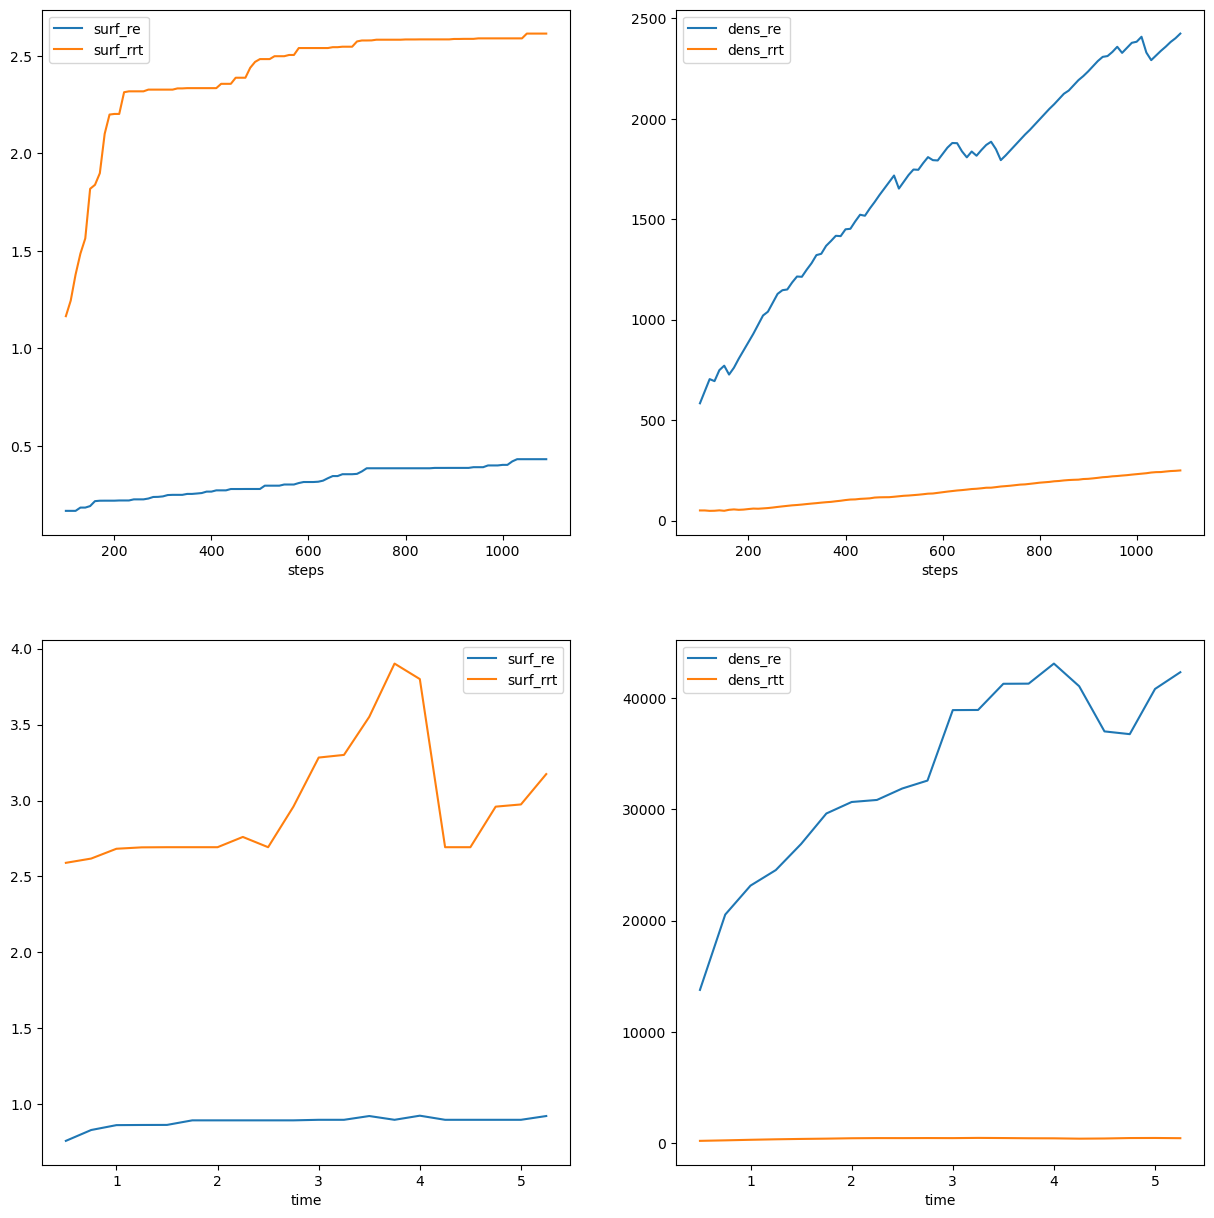

In [141]:
ev_steps = np.zeros([100,4])
ev_time = np.zeros([20,4])

steps = np.arange(100,1100,10)
times = np.arange(0.5,5.5,5/20)

for j  in range(100) :
    for k, func in enumerate([random_expansion, rrt_expansion]):
        random.seed(random_seed)
        
        env = Env()
        random_walls(env, 20)
        t = Tree([-0.5, -0.5])

        for i in range(steps[j]):
            func(t, env)

        ev_steps[j,2*k] , ev_steps[j,2*k+1]= surf(t)

plt.figure(figsize=[15,15])


plt.subplot(2,2,1)
plt.plot(steps, ev_steps[:,0], label="surf_re")
plt.plot(steps, ev_steps[:,2], label="surf_rrt")
plt.legend()
plt.xlabel("steps")

plt.subplot(2,2,2)
plt.plot(steps, ev_steps[:,1], label="dens_re")
plt.plot(steps, ev_steps[:,3], label="dens_rrt")
plt.xlabel("steps")
plt.legend()


for j  in range(20) :
    for k, func in enumerate([random_expansion, rrt_expansion]):
        random.seed(random_seed)
        
        env = Env()
        random_walls(env, 20)
        t = Tree([-0.5, -0.5])

        start_time = time.time()
        while ( time.time() - start_time) < times[j]:
            
            func(t, env)

        ev_time[j,2*k] , ev_time[j,2*k+1]= surf(t)

plt.subplot(2,2,3)
plt.plot(times, ev_time[:,0], label="surf_re")
plt.plot(times, ev_time[:,2], label="surf_rrt")
plt.xlabel("time")
plt.legend()

plt.subplot(2,2,4)
plt.plot(times, ev_time[:,1], label="dens_re")
plt.plot(times, ev_time[:,3], label="dens_rtt")
plt.xlabel("time")
plt.legend()

plt.show()

### Q2. Étudiez également l’impact du nombre de murs (défini dans l’appel à random_walls()) de l’environnement sur les performances d’exploration.

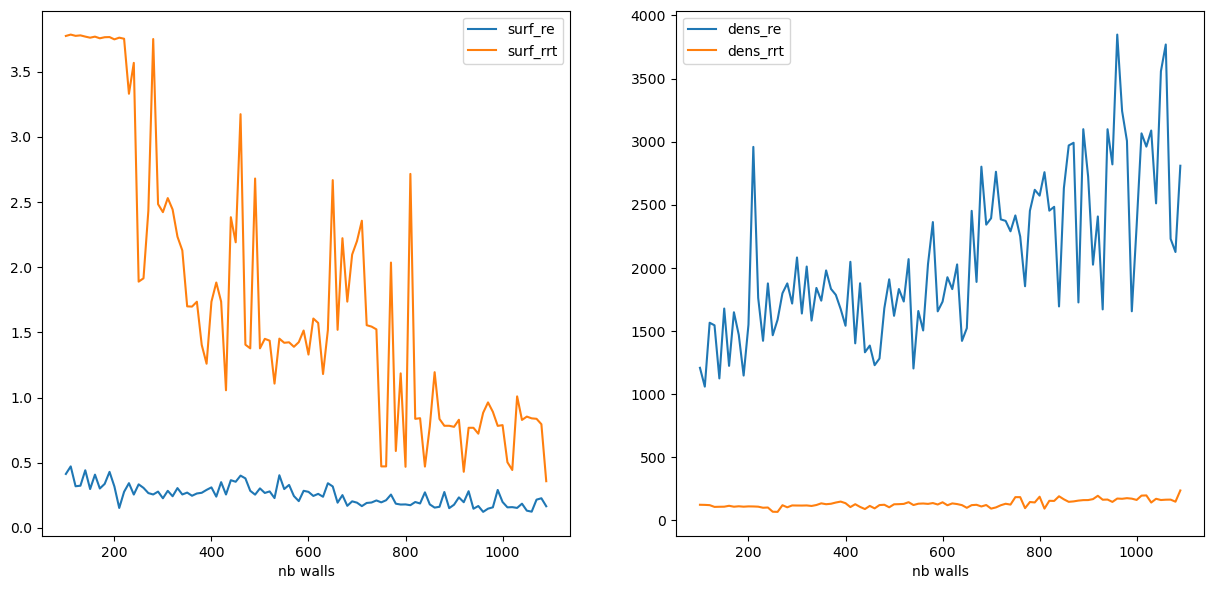

In [144]:
ev_walls = np.zeros([100,4])

nbr_walls = np.arange(1,101)

for j  in range(100) :
    for k, func in enumerate([random_expansion, rrt_expansion]):
        random.seed(random_seed)
        
        env = Env()
        random_walls(env, nbr_walls[j])
        t = Tree([-0.5, -0.5])

        for i in range(500):
            func(t, env)

        ev_walls[j,2*k] , ev_walls[j,2*k+1]= surf(t)

plt.figure(figsize=[15,15])


plt.subplot(2,2,1)
plt.plot(steps, ev_walls[:,0], label="surf_re")
plt.plot(steps, ev_walls[:,2], label="surf_rrt")
plt.legend()
plt.xlabel("nb walls")

plt.subplot(2,2,2)
plt.plot(steps, ev_walls[:,1], label="dens_re")
plt.plot(steps, ev_walls[:,3], label="dens_rrt")
plt.xlabel("nb walls")
plt.legend()

### Q3. Faites à nouveau l’étude en incluant deux variantes de rrt_expansion().

La première variante est la suivante : au lieu de choisir des actions dirigées vers l’échantillon sample, tirez simplement chaque nouvelle action aléatoirement. Cela devrait dégrader les performances de RRT.

La seconde variante consiste à utiliser une méthode approchée pour la recherche de plus proche voisin. Au lieu de parcourir l’ensemble des noeuds, tirez au sort un nombre fixe de noeuds parmi lesquels vous chercherez un plus proche voisin. À nombre d’itérations constant, cela devrait également dégrader les performances, par contre cela accélère les itérations, donc la comparaison à budget de temps de calcul constant est plus intéressante.

In [162]:
def rrt_expansion_v2(t, env):
    sample = [random.uniform(-1.0, 1.0), random.uniform(-1.0, 1.0)]
    nearest_neighbor = t
    d = Env.dist(t.state, sample)

    n = min(len(t.all_nodes), 10)

    rand_nodes = random.sample(t.all_nodes, n)

    for s in rand_nodes:  # Naive way to get the nearest neighbor
        d_tmp = Env.dist(s.state, sample)
        if d_tmp < d:
            nearest_neighbor = s
            d = d_tmp


    action = [np.clip(sample[0] - nearest_neighbor.state[0], -0.1, 0.1),
              np.clip(sample[1] - nearest_neighbor.state[1], -0.1, 0.1)]
    new_state = env.step(nearest_neighbor.state, action)
    if new_state:
        new_node = Tree(new_state, nearest_neighbor, False)
        nearest_neighbor.successors.append(new_node)
        t.all_nodes.append(new_node)

In [163]:
def rrt_expansion_v1(t, env):

    sample = [random.uniform(-1.0, 1.0), random.uniform(-1.0, 1.0)]
    
    nearest_neighbor = t

    d = Env.dist(t.state, sample)
    for s in t.all_nodes:  # Naive way to get the nearest neighbor
        d_tmp = Env.dist(s.state, sample)
        if d_tmp < d:
            nearest_neighbor = s
            d = d_tmp

    action = [random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)]
    
    new_state = env.step(nearest_neighbor.state, action)
    if new_state:
        new_node = Tree(new_state, nearest_neighbor, False)
        nearest_neighbor.successors.append(new_node)
        t.all_nodes.append(new_node)

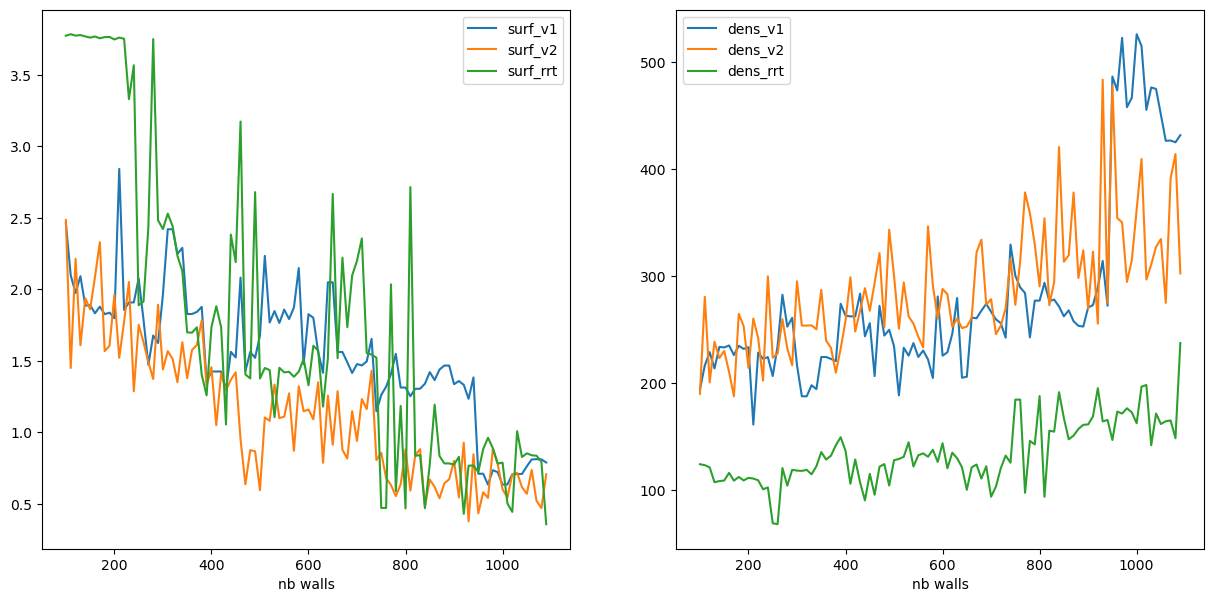

In [164]:
ev_walls = np.zeros([100,6])

nbr_walls = np.arange(1,101)

for j  in range(100) :
    for k, func in enumerate([rrt_expansion_v1, rrt_expansion_v2, rrt_expansion]):
        random.seed(random_seed)
        
        env = Env()
        random_walls(env, nbr_walls[j])
        t = Tree([-0.5, -0.5])

        for i in range(500):
            func(t, env)

        ev_walls[j,2*k] , ev_walls[j,2*k+1]= surf(t)

plt.figure(figsize=[15,7])


plt.subplot(1,2,1)
plt.plot(steps, ev_walls[:,0], label="surf_v1")
plt.plot(steps, ev_walls[:,2], label="surf_v2")
plt.plot(steps, ev_walls[:,4], label="surf_rrt")
plt.legend()
plt.xlabel("nb walls")

plt.subplot(1,2,2)
plt.plot(steps, ev_walls[:,1], label="dens_v1")
plt.plot(steps, ev_walls[:,3], label="dens_v2")
plt.plot(steps, ev_walls[:,5], label="dens_rrt")
plt.xlabel("nb walls")
plt.legend()

# Partie 2

### Q4. Exécutez part2.py.

Vous devriez obtenir ce résultat :

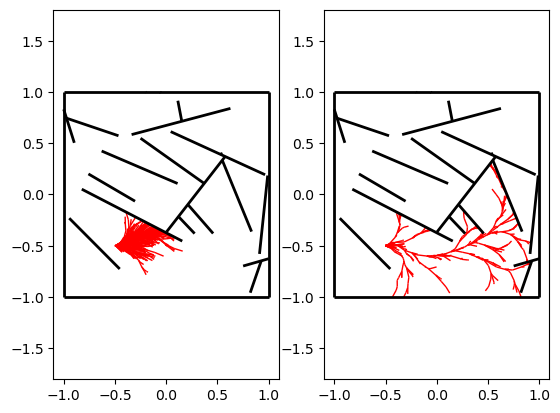

In [165]:
from part2 import *

L’environnement est légèrement modifié dans part2.py. Une orientation est rajoutée aux états, et les actions ne sont plus possibles dans toutes les directions. Chaque action effectuée doit avoir une direction comprise entre +25° et -25° par rapport à l’orientation actuelle. La nouvelle orientation est égale à la direction de l’action. Cela contraint évidemment davantage les trajectoires.

Dans le code, random_rrt_expansion(t, env) choisit les actions de façon aléatoire, et ne bénéfice donc pas des expansions classiques de RRT qui tentent de se rapprocher de l’échantillon cible (sample). 

Essayez de mettre au point une heuristique permettant de faire des expansions dirigées vers les cibles (en rajoutant éventuellement des orientations cibles). 

Faites à nouveau l’étude comparative de performances entre la fonction random_rrt_expansion() initiale et votre variante.

# Partie 3

### Q5. Ouvrez part3.py.

Dans ce fichier, le code a été légèrement modifié pour planifier le mouvement d’un robot non réduit à point, mais composé de deux segments formant un L. Ce robot 2D peut bouger en translation et rotation.

Exécutez le code, vous devriez obtenir ce résultat :

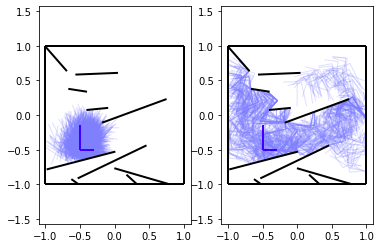

In [4]:
from part3 import *

/!\ Attention, le code retourne une erreur lorsque la position initiale du robot est en collision avec les murs de l’environnement. /!\

Collectez des résultats pour faire une gallerie de trajectoires non triviales du L obtenues grâce à RRT.

### Q6. Modifiez random_rrt_expansion() dans part3.py.

Dans le code, le choix de l’action est purement aléatoire. Mettez à nouveau au point une heuristique qui choisit une action se dirigeant vers la cible. Évaluez l’impact sur les performances.

### Q7. Modifiez le robot pour qu’il soit constitué de deux parties rigides reliées par une articulation.

Le mouvement du robot sera à la fois déterminé par les translations et rotations de sa base, mais aussi par les changements d’angle de l’articulation. Utilisez à nouveau RRT pour trouver des mouvements de ce robot évitant des obstacles, et présentez quelques exemples de résultats intéressants. N’oubliez pas de fournir le code permettant de reproduire les résultats.


### Q8. Question subsidiaire.

Modifiez part1.py pour que la recherche de voisin soit plus efficace, tout en restant correcte. Une possibilité : faites de temps en temps un fit de Kd-tree (le faire à chaque itération est inefficace). Mesurez l’impact sur le temps de calcul.